## Train pointwise ML model using first order gradients, but on wider stencil. Also with local norm.
## Also using the parallel perp division 
## also force the perp component to be downgradient diffusion

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

Here we attempt to a local normalization, with the hope that this helps improve the model performance. 


$$
\mathbf{\Psi} = \triangle x^2 |\nabla \overline{\mathbf{u}}| |\overline{\mathbf{S}}| g_{nn} (\nabla \overline{\mathbf{u}}/|\nabla \overline{\mathbf{u}}|, \overline{\mathbf{S}}/|\overline{\mathbf{S}}|)
$$


Here the idea is that $g_{nn}$ may learn something that is less reliant on the amplitudes of simulation. Here the magnitudes of the velocity gradients and slopes are local, so calculated over the quantities over the region that the prediction is made. 

A more general form will be of the type:

$$
\mathbf{\Psi} = \triangle x^2 |\nabla \overline{\mathbf{u}}| |\overline{\mathbf{S}}| g_{nn} (\nabla \overline{\mathbf{u}}/|\nabla \overline{\mathbf{u}}|, \overline{\mathbf{S}}/|\overline{\mathbf{S}}|, \triangle x)
$$ 
But then the question becomes if we want to let the nn adjust based on the length scales, or if we think that the g may be scale invariant (or we adjust some coeff in front). 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

2024-03-10 16:36:05.403241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 16:36:05.403265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 16:36:05.403271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
kind = 'MITgcm'
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

window_size=1

#fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'
    
# Open dataset
ML_data = datasets.MITgcm_all_transformer('-', '-', 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])

In [6]:
ML_data.read_datatree(MITgcm_bucket, keep_filt_scale=True, para_perp_out=True)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_200km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_400km_3D
Centered
Out para perp


In [7]:
%%time
ML_data.generate_test_train_batches(normalize=False)

Test and train batches split. Number of batches: 44-4


In [42]:
ANN_model = ML_classes.ANN(num_in = len(ML_data.input_channels), diffuse=True)

Diffuse


In [43]:
regress_sys = ML_classes.RegressionSystem(ANN_model, local_norm=True, diffuse=False)

In [44]:
%%time
regress_sys.train_system(ML_data, 31, 1)

Train loss step 0:  11.624622041528875 test loss: 7.25203001499176
Train loss step 1:  6.532819466157393 test loss: 6.8915135860443115
Train loss step 2:  6.344367742538452 test loss: 6.760765314102173
Train loss step 3:  6.245135914195668 test loss: 6.679792165756226
Train loss step 4:  6.176493146202781 test loss: 6.620230436325073
Train loss step 5:  6.132755420424721 test loss: 6.589184761047363
Train loss step 6:  6.103092659603465 test loss: 6.566442608833313
Train loss step 7:  6.0832989540967075 test loss: 6.548305869102478
Train loss step 8:  6.067107330669057 test loss: 6.529115200042725
Train loss step 9:  6.051297556270253 test loss: 6.520263910293579
Train loss step 10:  6.040101116353815 test loss: 6.509528040885925
Train loss step 11:  6.031793453476646 test loss: 6.4998250007629395
Train loss step 12:  6.0259492288936265 test loss: 6.4938249588012695
Train loss step 13:  6.020215153694153 test loss: 6.488789439201355
Train loss step 14:  6.014379815621809 test loss: 6.4

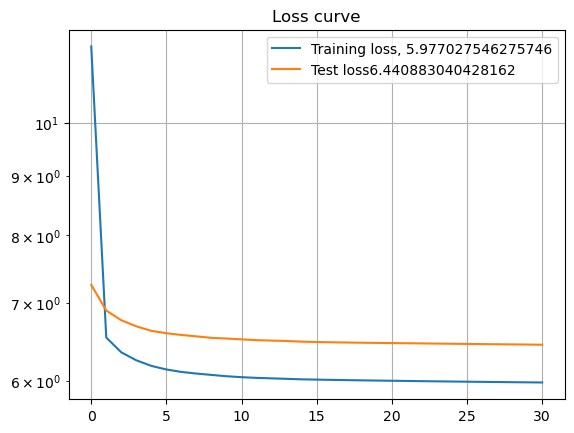

In [45]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve')
plt.grid()
plt.yscale('log')
plt.legend()

In [47]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MITgcm_window_1_local_norm_true_out_para_perp_diffuse'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MITgcm_all_window_1_local_norm_true_out_para_perp_diffuse'+'.nc'
regress_sys.save_weights_nc(model_nc)